In [109]:
# # Activate/Deactivate
# from google.colab import drive
# drive.mount('/content/drive')

In [110]:
# # Activate/Deactivate
# from google.colab import files
# uploaded = files.upload()

In [111]:
%load_ext google.colab.data_table
%matplotlib inline

# pd.options.mode.chained_assignment = None  # default='warn'
# pd.set_option('display.max_rows', 500)


The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


In [112]:
# Activate/Deactivate
# !pip install pingouin   

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import copy
from copy import deepcopy
import sys

import sklearn as sklearn
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import numpy.polynomial.polynomial as poly
from pingouin import corr as pingouin_corr
import seaborn as sns  # Convention alias for Seaborn
from IPython import get_ipython


In [114]:
# Collect datasets to study the subject of CO2 Emissions
# ------------------------------------------------------
df_energy_data = pd.read_csv("/content/drive/MyDrive/owid-energy-data.csv", sep=",")
# df_energy_data = pd.read_csv(
#     r".\ALL Assignments\Final Assgn_007_Mod7 (CO2 emissions)\1_F_CO2_Mn\data\ready\owid-energy-data.csv", sep=",")
df_energy_data.head(20)
df_energy_data.shape
# OUTPUT:   (22343, 128)
df_energy_data.columns
# OUTPUT:  ['country', 'year', 'iso_code', 'population', 'gdp',
#    'biofuel_cons_change_pct', 'biofuel_cons_change_twh',
#    'biofuel_cons_per_capita', 'biofuel_consumption',
#    'biofuel_elec_per_capita',
#    ...
#    'solar_share_elec', 'solar_share_energy', 'wind_cons_change_pct',
#    'wind_cons_change_twh', 'wind_consumption', 'wind_elec_per_capita',
#    'wind_electricity', 'wind_energy_per_capita', 'wind_share_elec',
#    'wind_share_energy']

Index(['country', 'year', 'iso_code', 'population', 'gdp',
       'biofuel_cons_change_pct', 'biofuel_cons_change_twh',
       'biofuel_cons_per_capita', 'biofuel_consumption',
       'biofuel_elec_per_capita',
       ...
       'solar_share_elec', 'solar_share_energy', 'wind_cons_change_pct',
       'wind_cons_change_twh', 'wind_consumption', 'wind_elec_per_capita',
       'wind_electricity', 'wind_energy_per_capita', 'wind_share_elec',
       'wind_share_energy'],
      dtype='object', length=128)

In [115]:
df_energy_codebook = pd.read_csv(
    "/content/drive/MyDrive/owid-energy-codebook.csv", sep='|')
df_energy_codebook.head(20)
df_energy_codebook.shape
# OUTPUT:   (128, 3)
df_energy_codebook.columns
# OUTPUT:   ['column', 'description', 'source']

Index(['column', 'description', 'source'], dtype='object')

In [116]:
# get an object name from globals (any object)
def get_obj_name(obj):
    name = [x for x in globals() if globals()[x] is obj][0]
    return name


# analze columns dataframes
def analyzeDataframes(myAnalysisDF, myAnalysisColumns):
    print(' ')
    print('*' * 60)
    print(f'RESULTS ANALYSIS DATAFRAME "{get_obj_name(myAnalysisDF)}"')
    print(f"AND ITS COLUMNS:")
    print(f"{myAnalysisColumns}")
    print('*' * 60)
    print(f"{get_obj_name(myAnalysisDF):}")
    print("myAnalysisDF.shape= ", f"{myAnalysisDF.shape}")
    print('*' * 40)
    print("myAnalysisDF.head(50)=")
    print(f"{myAnalysisDF.head(50)}")
    print("myAnalysisDF.tail(50)=")
    print(f"{myAnalysisDF.tail(50)}")
    print('*' * 40)

    print("myAnalysisDF.value_counts()=")
    print(f"{myAnalysisDF.value_counts()}")
    print('*' * 40)

    for myCol in myAnalysisColumns:
        try:
            print(f"myAnalysisDF.{myCol}.value_counts().sum()=")
            print(f"{myAnalysisDF[myCol].value_counts().sum()}")
            print('*' * 40)
        except AttributeError as error:     # Errors:   AttributeError, IndexError, ValueError, TypeError
            print(f"The {myCol} sum Error is: {error}.")
        # finally:
            print('*' * 40)

        try:
            print(f"myAnalysisDF.{myCol}.unique().shape=")
            print(f"{myAnalysisDF[myCol].unique().shape}")
            print('*' * 40)
        except AttributeError as error:
            print(f"The {myCol} shape Error is: {error}.")
        # finally:
            print('*' * 40)
            # return

        print(f"myAnalysisDF.{myCol}.value_counts()")
        print(f"{myAnalysisDF[myCol].value_counts()}")
        print('*' * 40)
        print('End*' * 10)
        print('*' * 40)
        print(' ')
        print('*' * 40)



In [117]:
# ***************************************************************************
# 7. for each column:
#    1.	find any non-default missing values (there may be more than one)
#    2.	decide what default NULL values to replace them with
#    3.	replace the missing values
#    4.	calculate the percentage of missing values
#
# Tactics:
# -------
#    A. looking at all the unique values
#    B. sorting and looking at the edges
#    C. casting to a type
#    D. looking at the frequency
#
def find_missing_values(myDF, column_name):

    def print_separator(sep, num, msg):
        print("\n")
        print(sep * num)
        print(f"{msg}")
        print(sep * num)

    def look_at_unique_values(column):
        unique_values_cutoff = 160  # bv. 50 or 160
        unique_values = column.unique()
        num_unique_values = len(unique_values)
        if num_unique_values == len(column):
            print(
                f"Each value in the column is unique (total: {num_unique_values})")
        elif num_unique_values < unique_values_cutoff:
            print(f"Less than {unique_values_cutoff} unique values:")
            # We may get an error when sorting
            try:
                sorted = np.sort(unique_values)
                print("Values are sorted")
                print(list(sorted))
            except:
                print("Could not sort values")
                print(list(unique_values))
        else:
            print(
                f"More than {unique_values_cutoff} unique values (total: {num_unique_values})")

    def look_at_edges(df, column_name):
        # inner function
        def show_head_and_tail(values):
            num_items_to_slice = 10
            print(list(values)[:num_items_to_slice])
            print(list(values)[-num_items_to_slice:])

        column = df[column_name]
        unique_values = column.unique()
        try:
            sorted = np.sort(unique_values)
            print("Unique values sorted, head and tail:")
            print("\n")
            show_head_and_tail(sorted)
        except TypeError as error:
            print(f"Could not sort values: {error}")
            print("..so let's try filtering NULL values and then sorting")
            non_null_uniques = df.loc[~df[column_name].isnull(
            ), column_name].unique()
            sorted = np.sort(non_null_uniques)
            print("\n")
            show_head_and_tail(sorted)

    def cast_to_type(column):
        myDataTypes = ["datetime64", "int64", "float64", "string", "bool"]

        # stopLoop = False
        for maybe_type in myDataTypes:
            try:
                column.astype(maybe_type)
                print(f"Casting to {maybe_type} was successful")
                print('*' * 40)
                break
            except ValueError as error:
                # stopLoop = True
                print(f"Could not cast to {maybe_type}: {error}")
                print('*' * 40)
            # finally:
            #     print(" ")

    def find_non_default_missing_values(df, column_name):
        long_separator_amount = 80
        short_separator_amount = 40

        print_separator("*", long_separator_amount,
                        f"Finding non default missing values for column \"{column_name}\"")

        print(
            f"Column \"{column_name}\" has datatype: {df.dtypes[column_name]}")

        column = df[column_name]

        # Tactic A
        print_separator("-", short_separator_amount,
                        "A: Looking at unique values")
        look_at_unique_values(column)

        # Tactic B
        print_separator("-", short_separator_amount,
                        "B: Sorting and looking at the edges")
        look_at_edges(df, column_name)

        # Tactic C
        print_separator("-", short_separator_amount,
                        f'C: Casting to type: ["datetime64", "int64", "float64", "string", "bool"]')   # {maybe_type}")
        cast_to_type(column)

        # Tactic D
        print_separator("-", short_separator_amount, "D: Looking at frequency")
        print(column.value_counts(dropna=False))

        print("\n")

    find_non_default_missing_values(myDF, column_name)  # , maybe_type)




In [118]:
# Generate statistics for two columns at a time
def generateStatistics(myAllDF, twoAnalysisColumns):
    nameDF = get_obj_name(myAllDF)

    col1 = twoAnalysisColumns[0]
    col2 = twoAnalysisColumns[1]

    print(' ')
    print('*' * 40)
    print("            << Statistics >>            ")
    print(f"using dataset '{nameDF}' and columns= {twoAnalysisColumns}")
    print('*' * 40)

    df_ALL = myAllDF[[col1, col2]].dropna()
    print(f"ALL Dataframe: 'df_ALL'")
    print(df_ALL.head())
    print(df_ALL.columns)
    print('*' * 40)

    # Let us calculate the Correlation Coefficients:
    # ---------------------------------------------

    # 1) Pandas internal Correlation Coefficient:
    df_ALL.corr(method='pearson')
    # OUTPUT: example
    """
            GDP      Gini
    GDP   1.000000 -0.429966
    Gini -0.429966  1.000000
    """
    df_corr_1 = df_ALL.corr(method='pearson')
    print(type(df_corr_1))
    print(df_corr_1)
    print('*' * 40)

    corr1 = round(df_corr_1.iloc[1][col1], 6)
    print(type(corr1))
    print("corr1= ", f"{corr1}")
    # print(f"{corr1= }")
    print('*' * 40)

    # 2) Correlation Coefficient using pingouin library:
    pingouin_corr(df_ALL[col1], df_ALL[col2])
    # OUTPUT:  example
    """
                n         r           CI95%         p-val       BF10  power
    pearson  1811 -0.429966  [-0.47, -0.39]  2.203046e-82  4.744e+78    1.0
    """

    df_corr_2 = pingouin_corr(df_ALL[col1], df_ALL[col2])
    print(type(df_corr_2))
    print(df_corr_2)
    print('*' * 40)

    corr2_r = round(df_corr_2.iloc[0]['r'], 6)
    corr2_p_val = round(df_corr_2.iloc[0]['p-val'], 6)
    print("corr2_r= ", f"{corr2_r}")
    # print(f"{corr2_r= }")
    print("corr2_p_val= ", f"{corr2_p_val}")
    # print(f"{corr2_p_val= }")

    print('*' * 40)
    print('*' * 40)


In [119]:
#
#
# **********************************************************************************
# **********************************************************************************
# **********************************************************************************
#                             << ANSWER ALL QUESTIONS >>
# **********************************************************************************
# **********************************************************************************
# **********************************************************************************
#
#

In [120]:
# *********************************************************************
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Q1: Biggest predictor of CO2 output per capita of a country
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

# Collect data for Q1
# -------------------
df_co2_gdp = pd.read_csv(
    "/content/drive/MyDrive/co2-emissions-and-gdp.csv", sep=",")  # , encoding="ISO-8859-1")
df_co2_gdp.head(20)
df_co2_gdp.shape
# OUTPUT:   (7795, 6)
df_co2_gdp.columns
# OUTPUT:   ['Entity', 'Code', 'Year', 'Annual CO2 emissions', 'Annual consumption-based CO2 emissions', 'GDP per capita']

# df_co2_gdp.dropna(inplace=True)
# df_co2_gdp.shape
# OUTPUT:   (3470, 6)

df_co2_gdp.rename(columns={'Entity': 'country', 'Year': 'year', 'Annual CO2 emissions': 'annual_co2_emissions',
                  'GDP per capita': 'gdp_per_capita'}, inplace=True)
df_co2_gdp = df_co2_gdp[['country', 'year', 'annual_co2_emissions',
                         'gdp_per_capita']]


# Collect data for Q1
# -------------------
df_co2_kaya = pd.read_csv(
    "/content/drive/MyDrive/kaya-identity-co2.csv", sep=",")  # , encoding="ISO-8859-1")
df_co2_kaya.head(20)
df_co2_kaya.shape
# OUTPUT:   (7795, 6)
df_co2_kaya.columns
# OUTPUT:   ['Entity', 'Code', 'Year', 'Annual CO2 emissions',
#    'Annual CO2 emissions per unit energy (kg per kilowatt-hour)',
#    'Annual CO2 emissions per GDP (kg per $PPP)',
#    'Primary energy consumption per GDP (kWh/$)', 'GDP per capita',
#    '417485-annotations', 'Population (historical estimates)']

# df_co2_kaya.dropna(inplace=True)
df_co2_kaya.shape
# OUTPUT:   (14925, 10)

df_co2_kaya.rename(columns={
                   'Entity': 'country', 'Year': 'year', 'Annual CO2 emissions': 'annual_co2_emissions', 'Annual CO2 emissions per unit energy (kg per kilowatt-hour)': 'co2_per_unit_energy',
                   'Annual CO2 emissions per GDP (kg per $PPP)': 'co2_per_gdp', 'Primary energy consumption per GDP (kWh/$)':
                   'energy_per_gdp', 'GDP per capita': 'gdp_per_capita', 'Population (historical estimates)': 'population'}, inplace=True)
df_co2_kaya = df_co2_kaya[['country', 'year', 'annual_co2_emissions',
                           'co2_per_unit_energy', 'co2_per_gdp', 'energy_per_gdp', 'gdp_per_capita', 'population']]

df_co2_kaya.head(20)
df_co2_kaya.shape
# OUTPUT:   (14925, 8)
df_co2_kaya.columns
# OUTPUT:   ['country', 'year', 'annual_co2_emissions', 'co2_per_unit_energy',
#    'co2_per_gdp', 'energy_per_gdp', 'gdp_per_capita', 'population']


Index(['country', 'year', 'annual_co2_emissions', 'co2_per_unit_energy',
       'co2_per_gdp', 'energy_per_gdp', 'gdp_per_capita', 'population'],
      dtype='object')

In [121]:

'''
Q1 Analysis: 'CO2 output per capita' versus --> [Candidate Predictors]
Candidates I:  GDP per capita, diets, number of cars per capita, various energy source, mobility and other factors
Candidates II: Population, GDP per capita, 'energy_per_gdp', 'co2_per_unit_energy', 'co2_per_gdp'

For my analysis, I have chosen the second group (Candidates II).

'''

# Analyze dataframe 'df_co2_gdp'
analyzeDataframes(df_co2_gdp, df_co2_gdp.columns)

# To generate statistics, determine those columns which can be a good predictor of CO2 output per capita of a country
col_under_analysis = 'annual_co2_emissions'
col_candidate_predictors = ['population', 'gdp_per_capita',
                            'co2_per_gdp', 'energy_per_gdp', 'co2_per_unit_energy']

# Generate Statitics using dataset "df_co2_gdp"
generateStatistics(df_co2_gdp, ['gdp_per_capita', 'annual_co2_emissions'])
# OUTPUT:
"""
1) Correlation Coefficient using Pandas itself:
                      gdp_per_capita  annual_co2_emissions
gdp_per_capita              1.000000              0.984548
annual_co2_emissions        0.984548              1.000000

2) Correlation Coefficient using pingouin library:
            n         r         CI95%  p-val BF10  power
pearson  5690  0.984548  [0.98, 0.99]    0.0  nan    1.0
"""

 
************************************************************
RESULTS ANALYSIS DATAFRAME "df_co2_gdp"
AND ITS COLUMNS:
Index(['country', 'year', 'annual_co2_emissions', 'gdp_per_capita'], dtype='object')
************************************************************
df_co2_gdp
myAnalysisDF.shape=  (7795, 4)
****************************************
myAnalysisDF.head(50)=
        country  year  annual_co2_emissions  gdp_per_capita
0   Afghanistan  1990          2.603238e+06             NaN
1   Afghanistan  1991          2.427366e+06             NaN
2   Afghanistan  1992          1.379462e+06             NaN
3   Afghanistan  1993          1.333055e+06             NaN
4   Afghanistan  1994          1.281602e+06             NaN
5   Afghanistan  1995          1.230463e+06             NaN
6   Afghanistan  1996          1.164920e+06             NaN
7   Afghanistan  1997          1.084127e+06             NaN
8   Afghanistan  1998          1.029157e+06             NaN
9   Afghanistan  1999       

'\n1) Correlation Coefficient using Pandas itself:\n                      gdp_per_capita  annual_co2_emissions\ngdp_per_capita              1.000000              0.984548\nannual_co2_emissions        0.984548              1.000000\n\n2) Correlation Coefficient using pingouin library:\n            n         r         CI95%  p-val BF10  power\npearson  5690  0.984548  [0.98, 0.99]    0.0  nan    1.0\n'

In [122]:
# Generate Statitics for all candidate predictors using dataset "df_co2_kaya"
for col in col_candidate_predictors:
    generateStatistics(df_co2_kaya, [col, 'annual_co2_emissions'])
    print('*' * 40)
# OUTPUT:
"""
1) Correlation Coefficient using Pandas itself:
                      co2_per_unit_energy  annual_co2_emissions
co2_per_unit_energy              1.000000              0.051652
annual_co2_emissions             0.051652              1.000000

2) Correlation Coefficient using pingouin library:
            n         r         CI95%         p-val     BF10     power
pearson  9958  0.051652  [0.03, 0.07]           0.0  7470.51  0.999309
"""

 
****************************************
            << Statistics >>            
using dataset 'df_co2_kaya' and columns= ['population', 'annual_co2_emissions']
****************************************
ALL Dataframe: 'df_ALL'
   population  annual_co2_emissions
0   9565154.0             1006917.0
1   9783153.0             1091159.0
2  10010037.0             1281865.0
3  10247782.0             1223391.0
4  10494491.0              941232.0
Index(['population', 'annual_co2_emissions'], dtype='object')
****************************************
<class 'pandas.core.frame.DataFrame'>
                      population  annual_co2_emissions
population              1.000000              0.893219
annual_co2_emissions    0.893219              1.000000
****************************************
<class 'numpy.float64'>
corr1=  0.893219
****************************************
<class 'pandas.core.frame.DataFrame'>
             n         r        CI95%  p-val BF10  power
pearson  12397  0.893219  [0.89

'\n1) Correlation Coefficient using Pandas itself:\n                      co2_per_unit_energy  annual_co2_emissions\nco2_per_unit_energy              1.000000              0.051652\nannual_co2_emissions             0.051652              1.000000\n\n2) Correlation Coefficient using pingouin library:\n            n         r         CI95%         p-val     BF10     power\npearson  9958  0.051652  [0.03, 0.07]           0.0  7470.51  0.999309\n'

In [123]:
'''
And NOW implement an integration analysis of CO2 Emissions Predictors, combined together !

This implies applying of the following two "CO2 Emissions" formulas:

Method I = [ CO2 emissions = Population * (GDP /  Population) * (CO2 emissions per $) ]

Method II = [ CO2 Emissions = Population * (GDP /  Population) * (Energy / GDP) * (CO2 / Energy) ]


The corresponding columns for both methods are as follow:

Method I = [ 'annual_co2_emissions' vs. { 'population' * 'gdp_per_capita' * 'co2_per_gdp' } ]

Method II = [ 'annual_co2_emissions' vs. { 'population' * 'gdp_per_capita' * 'energy_per_gdp' * 'co2_per_unit_energy' } ]

'''

'\nAnd NOW implement an integration analysis of CO2 Emissions Predictors, combined together !\n\nThis implies applying of the following two "CO2 Emissions" formulas:\n\nMethod I = [ CO2 emissions = Population * (GDP /  Population) * (CO2 emissions per $) ]\n\nMethod II = [ CO2 Emissions = Population * (GDP /  Population) * (Energy / GDP) * (CO2 / Energy) ]\n\n\nThe corresponding columns for both methods are as follow:\n\nMethod I = [ \'annual_co2_emissions\' vs. { \'population\' * \'gdp_per_capita\' * \'co2_per_gdp\' } ]\n\nMethod II = [ \'annual_co2_emissions\' vs. { \'population\' * \'gdp_per_capita\' * \'energy_per_gdp\' * \'co2_per_unit_energy\' } ]\n\n'

In [124]:
# Calculation of CO2 emissions driver using Method I ['co2_driver_method_1']
df_co2_kaya['co2_driver_method_1'] = df_co2_kaya['population'] * \
    df_co2_kaya['gdp_per_capita'] * df_co2_kaya['co2_per_gdp']


# Calculation of CO2 emissions driver using Method II ['co2_driver_method_2']
df_co2_kaya['co2_driver_method_2'] = df_co2_kaya['population'] * df_co2_kaya['gdp_per_capita'] * \
    df_co2_kaya['energy_per_gdp'] * df_co2_kaya['co2_per_unit_energy']

df_co2_kaya.head(20)
df_co2_kaya.shape
# OUTPUT:   (14925, 8) --> (14925, 10)
df_co2_kaya.columns
# OUTPUT:   ['country', 'year', 'annual_co2_emissions', 'co2_per_unit_energy', 'co2_per_gdp', 'energy_per_gdp', 'gdp_per_capita',
#            'population', 'co2_driver_method_1', 'co2_driver_method_2']



Index(['country', 'year', 'annual_co2_emissions', 'co2_per_unit_energy',
       'co2_per_gdp', 'energy_per_gdp', 'gdp_per_capita', 'population',
       'co2_driver_method_1', 'co2_driver_method_2'],
      dtype='object')

In [125]:
# Generate Statitics using dataset "df_co2_kaya", based on [ CO2 Method I ]
generateStatistics(
    df_co2_kaya, ['co2_driver_method_1', 'annual_co2_emissions'])
# OUTPUT:
"""
1) Correlation Coefficient using Pandas itself:
                      co2_driver_method_1  annual_co2_emissions
co2_driver_method_1              1.000000              0.999905
annual_co2_emissions             0.999905              1.000000

2) Correlation Coefficient using pingouin library:
            n         r       CI95%  p-val BF10  power
pearson  8533  0.999905  [1.0, 1.0]    0.0  inf    1.0
"""


 
****************************************
            << Statistics >>            
using dataset 'df_co2_kaya' and columns= ['co2_driver_method_1', 'annual_co2_emissions']
****************************************
ALL Dataframe: 'df_ALL'
   co2_driver_method_1  annual_co2_emissions
0         8.760725e+08             1006917.0
1         9.482458e+08             1091159.0
2         1.112105e+09             1281865.0
3         1.060215e+09             1223391.0
4         8.154471e+08              941232.0
Index(['co2_driver_method_1', 'annual_co2_emissions'], dtype='object')
****************************************
<class 'pandas.core.frame.DataFrame'>
                      co2_driver_method_1  annual_co2_emissions
co2_driver_method_1              1.000000              0.999905
annual_co2_emissions             0.999905              1.000000
****************************************
<class 'numpy.float64'>
corr1=  0.999905
****************************************
<class 'pandas.core.frame.D

'\n1) Correlation Coefficient using Pandas itself:\n                      co2_driver_method_1  annual_co2_emissions\nco2_driver_method_1              1.000000              0.999905\nannual_co2_emissions             0.999905              1.000000\n\n2) Correlation Coefficient using pingouin library:\n            n         r       CI95%  p-val BF10  power\npearson  8533  0.999905  [1.0, 1.0]    0.0  inf    1.0\n'

In [126]:
# Generate Statitics using dataset "df_co2_kaya", based on [ CO2 Method II ]
generateStatistics(
    df_co2_kaya, ['co2_driver_method_2', 'annual_co2_emissions'])
# OUTPUT:
"""
1) Correlation Coefficient using Pandas itself:
                      co2_driver_method_2  annual_co2_emissions
co2_driver_method_2              1.000000              0.999878
annual_co2_emissions             0.999878              1.000000

2) Correlation Coefficient using pingouin library:
            n         r       CI95%  p-val BF10  power
pearson  7109  0.999878  [1.0, 1.0]    0.0  inf    1.0
"""


 
****************************************
            << Statistics >>            
using dataset 'df_co2_kaya' and columns= ['co2_driver_method_2', 'annual_co2_emissions']
****************************************
ALL Dataframe: 'df_ALL'
    co2_driver_method_2  annual_co2_emissions
15         1.457527e+09             1756302.0
16         1.613741e+09             1978463.0
17         1.679613e+09             2094581.0
18         2.016474e+09             2519954.0
19         2.263663e+09             2821540.0
Index(['co2_driver_method_2', 'annual_co2_emissions'], dtype='object')
****************************************
<class 'pandas.core.frame.DataFrame'>
                      co2_driver_method_2  annual_co2_emissions
co2_driver_method_2              1.000000              0.999878
annual_co2_emissions             0.999878              1.000000
****************************************
<class 'numpy.float64'>
corr1=  0.999878
****************************************
<class 'pandas.core.f

'\n1) Correlation Coefficient using Pandas itself:\n                      co2_driver_method_2  annual_co2_emissions\nco2_driver_method_2              1.000000              0.999878\nannual_co2_emissions             0.999878              1.000000\n\n2) Correlation Coefficient using pingouin library:\n            n         r       CI95%  p-val BF10  power\npearson  7109  0.999878  [1.0, 1.0]    0.0  inf    1.0\n'

In [127]:
# *********************************************************************
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Q2: Biggest strides in decreasing CO2 output
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

# Collect data for Q2
# -------------------
df_co2_emissions = pd.read_csv(
    "/content/drive/MyDrive/owid-co2-data.csv", sep=",")  # , encoding="ISO-8859-1")
df_co2_emissions.head(20)
df_co2_emissions.shape
# OUTPUT:   (26008, 60)
df_co2_emissions.columns
# OUTPUT:   ['country', 'year', 'iso_code', 'population', 'gdp', 'cement_co2',
#    'cement_co2_per_capita', 'co2', 'co2_growth_abs', 'co2_growth_prct',
#    'co2_per_capita', 'co2_per_gdp', 'co2_per_unit_energy', 'coal_co2',
#    'coal_co2_per_capita', 'consumption_co2', 'consumption_co2_per_capita',
#    'consumption_co2_per_gdp', 'cumulative_cement_co2', 'cumulative_co2',
#    'cumulative_coal_co2', 'cumulative_flaring_co2', 'cumulative_gas_co2',
#    'cumulative_oil_co2', 'cumulative_other_co2', 'energy_per_capita',
#    'energy_per_gdp', 'flaring_co2', 'flaring_co2_per_capita', 'gas_co2',
#    'gas_co2_per_capita', 'ghg_excluding_lucf_per_capita', 'ghg_per_capita',
#    'methane', 'methane_per_capita', 'nitrous_oxide',
#    'nitrous_oxide_per_capita', 'oil_co2', 'oil_co2_per_capita',
#    'other_co2_per_capita', 'other_industry_co2',
#    'primary_energy_consumption', 'share_global_cement_co2',
#    'share_global_co2', 'share_global_coal_co2',
#    'share_global_cumulative_cement_co2', 'share_global_cumulative_co2',
#    'share_global_cumulative_coal_co2',
#    'share_global_cumulative_flaring_co2',
#    'share_global_cumulative_gas_co2', 'share_global_cumulative_oil_co2',
#    'share_global_cumulative_other_co2', 'share_global_flaring_co2',
#    'share_global_gas_co2', 'share_global_oil_co2',
#    'share_global_other_co2', 'total_ghg', 'total_ghg_excluding_lucf',
#    'trade_co2', 'trade_co2_share']



Index(['country', 'year', 'iso_code', 'population', 'gdp', 'cement_co2',
       'cement_co2_per_capita', 'co2', 'co2_growth_abs', 'co2_growth_prct',
       'co2_per_capita', 'co2_per_gdp', 'co2_per_unit_energy', 'coal_co2',
       'coal_co2_per_capita', 'consumption_co2', 'consumption_co2_per_capita',
       'consumption_co2_per_gdp', 'cumulative_cement_co2', 'cumulative_co2',
       'cumulative_coal_co2', 'cumulative_flaring_co2', 'cumulative_gas_co2',
       'cumulative_oil_co2', 'cumulative_other_co2', 'energy_per_capita',
       'energy_per_gdp', 'flaring_co2', 'flaring_co2_per_capita', 'gas_co2',
       'gas_co2_per_capita', 'ghg_excluding_lucf_per_capita', 'ghg_per_capita',
       'methane', 'methane_per_capita', 'nitrous_oxide',
       'nitrous_oxide_per_capita', 'oil_co2', 'oil_co2_per_capita',
       'other_co2_per_capita', 'other_industry_co2',
       'primary_energy_consumption', 'share_global_cement_co2',
       'share_global_co2', 'share_global_coal_co2',
       'share_glo

In [128]:
# IMPORTANT COLUMNS:
# ['country', 'year', 'iso_code', 'population', 'gdp', 'co2', 'co2_growth_abs', 'co2_growth_prct',
#    'co2_per_capita', 'co2_per_gdp', 'co2_per_unit_energy', 'consumption_co2_per_capita',
#    'consumption_co2_per_gdp', 'energy_per_capita', 'energy_per_gdp',
#    'primary_energy_consumption', 'share_global_co2', 'trade_co2', 'trade_co2_share']

df_co2_emissions2 = df_co2_emissions[['country', 'year', 'iso_code', 'population', 'gdp', 'co2', 'co2_growth_abs', 'co2_growth_prct',
                                      'co2_per_capita', 'co2_per_gdp', 'co2_per_unit_energy', 'consumption_co2_per_capita',
                                     'consumption_co2_per_gdp', 'energy_per_capita', 'energy_per_gdp',
                                      'primary_energy_consumption', 'share_global_co2', 'trade_co2', 'trade_co2_share']
                                     ]
df_co2_emissions2.head(20)
df_co2_emissions2.shape
# OUTPUT:   (26008, 60) --> (26008, 19)
df_co2_emissions2.columns

# df_co2_emissions2.dropna(inplace=True)
df_co2_emissions2.shape
# OUTPUT:   (26008, 60) --> (26008, 19) --> (3397, 19)
df_co2_emissions2.head(50)

df_co2_emissions2.country.value_counts()
len(df_co2_emissions2.country.unique())
# OUTPUT:  118
df_co2_emissions2.year.min()
# OUTPUT:   min=1990
df_co2_emissions2.year.max()
# OUTPUT:   max=2020 ?

2020

In [129]:
df_co2_1990 = df_co2_emissions2.loc[df_co2_emissions2['year'] == 1990]
df_co2_1990
df_co2_1990.shape
# OUTPUT:   (3397, 19) --> (113, 19)

df_co2_emissions2.tail(20)

# Select Relevante columns
df_co2_strides = df_co2_emissions[['country', 'year', 'co2_per_capita']]
df_co2_strides

df_co2_strides.reset_index(drop=True, inplace=True)
df_co2_strides

df_co2_strides.shape
# OUTPUT:   (26008, 3)

# df_co2_strides.dropna(inplace=True)
# df_co2_strides = df_co2_strides.dropna()
# df_co2_strides.shape
# OUTPUT:   (26008, 3) --> (24032, 3)

(26008, 3)

In [130]:
# Due to the bad quality of data before year 1990, I have excluded that data:
df_co2_strides_2 = df_co2_strides.loc[df_co2_strides['year'] >= 1990]
df_co2_strides_2
df_co2_strides_2.shape
# OUTPUT:   (26008, 3) --> (7627, 3)        OUD: (7253, 3)

df_co2_strides_2 = df_co2_strides_2.dropna()
df_co2_strides_2
df_co2_strides_2.shape
# OUTPUT:   (7627, 3)  --> (7253, 3)

# Sort my basic clean dataset
df_co2_strides_2_sorted = df_co2_strides_2.sort_values(
    by=['country', 'year'], ascending=[True, True])
df_co2_strides_2_sorted


,country,year,co2_per_capita
41,Afghanistan,1990,0.210
42,Afghanistan,1991,0.183
43,Afghanistan,1992,0.095
44,Afghanistan,1993,0.084
45,Afghanistan,1994,0.075
...,...,...,...
26003,Zimbabwe,2016,0.765
26004,Zimbabwe,2017,0.673
26005,Zimbabwe,2018,0.821
26006,Zimbabwe,2019,0.748


In [131]:
# Take one country as an example and then create a generic function for ALL COUNTRIES
# Test this code:
# df_co2_strides_2_sorted = df_co2_strides_2_sorted.loc[
#     df_co2_strides_2_sorted['country'] == "Afghanistan"]
# df_co2_strides_2_sorted['biggest_stride_decreasing_co2'] = df_co2_strides_2_sorted['co2_per_capita'] - \
#     df_co2_strides_2_sorted['co2_per_capita'].shift(periods=1, fill_value=0)
# df_co2_strides_2_sorted

In [132]:
# Make list of all countries
countryList = df_co2_strides_2_sorted.country.unique().tolist()
countryList.sort()
type(countryList)
len(countryList)
countryList

# Short lists of countries for Testing
countryList2 = []
countryList3 = ["Afghanistan"]
countryList4 = ["Afghanistan", "Turkmenistan", "United States"]


In [133]:
# Add a new column for the "Biggest strides in decreasing CO2 output"
df_co2_strides_2_sorted = df_co2_strides_2_sorted.assign(
    co2_stride=0)

In [134]:
# Process ALL Countries
def processCountries(myCtryList, myDF_AllCountries):

    # Capture an empty country list or dataframe
    if (len(myCtryList) == 0) or (len(myDF_AllCountries) == 0):
        print(
            f"MyError: [the dataframe '{get_obj_name(myDF_AllCountries)}' is EMPTY] OR [the countrylist '{get_obj_name(myCtryList)}' is EMPTY].")
        return myDF_AllCountries

    # Create an empty dataframe as a basic dataframe for collecting statistics of all countries
    myDF = pd.DataFrame(
        data=None, columns=myDF_AllCountries.columns, index=myDF_AllCountries.index)
    myDF.dropna(inplace=True)

    # Loop over countries
    for myCountry in myCtryList:

        myDF_oneCtry = myDF_AllCountries.loc[myDF_AllCountries['country'] == myCountry]

        # Calculate the CO2 strides for all countries and for all years [co2_stride = co2_stride_Yn - co2_stride_Yn-1]
        myDF_oneCtry['co2_stride'] = myDF_oneCtry['co2_per_capita'] - \
            myDF_oneCtry['co2_per_capita'].shift(periods=1, fill_value=0)

        minimum_year = myDF_oneCtry['year'].min()

        # As a BENCHMARK set value of year 1990 to zero
        myDF_oneCtry['co2_stride'] = np.where(
            myDF_oneCtry['year'].eq(minimum_year), 0, myDF_oneCtry['co2_stride'])

        # merge the results with the ALL countries dataframe:
        myDF = pd.concat([myDF, myDF_oneCtry])

    myDF.reset_index(drop=True, inplace=True)

    return myDF


# Calculate the CO2 strides for all countries for all years from year 1990
df_co2_strides_3 = processCountries(countryList, df_co2_strides_2_sorted)

df_co2_strides_3.reset_index(drop=True, inplace=True)

print(' ')
print('*' * 60)
print("[CO2 strides for all countries for all years]:")
print(df_co2_strides_3.shape)
print('*' * 60)
print(df_co2_strides_3.head(60))
print('*' * 60)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


 
************************************************************
[CO2 strides for all countries for all years]:
(7253, 4)
************************************************************
        country  year  co2_per_capita  co2_stride
0   Afghanistan  1990           0.210       0.000
1   Afghanistan  1991           0.183      -0.027
2   Afghanistan  1992           0.095      -0.088
3   Afghanistan  1993           0.084      -0.011
4   Afghanistan  1994           0.075      -0.009
5   Afghanistan  1995           0.068      -0.007
6   Afghanistan  1996           0.062      -0.006
7   Afghanistan  1997           0.056      -0.006
8   Afghanistan  1998           0.052      -0.004
9   Afghanistan  1999           0.040      -0.012
10  Afghanistan  2000           0.036      -0.004
11  Afghanistan  2001           0.037       0.001
12  Afghanistan  2002           0.047       0.010
13  Afghanistan  2003           0.050       0.003
14  Afghanistan  2004           0.036      -0.014
15  Afghanistan  20

In [135]:
print(df_co2_strides_3.columns.to_list())
# OUTPUT:
# ['country', 'year', 'co2_per_capita', 'co2_stride']

# Implement data quality (DQ) analysis
# analysisColumnsList = df_co2_strides_3.columns.to_list()
# analyzeDataframes(df_co2_strides_3, analysisColumnsList)

['country', 'year', 'co2_per_capita', 'co2_stride']


In [136]:
# Calculate biggest decrease co2
def calculate_biggest_decrease_co2(myCtryList, myDF_AllCountries):

    # Capture an empty country list or dataframe
    if (len(myCtryList) == 0) or (len(myDF_AllCountries) == 0):
        print(
            f"MyError: [the dataframe '{get_obj_name(myDF_AllCountries)}' is EMPTY] OR [the countrylist '{get_obj_name(myCtryList)}' is EMPTY].")
        return myDF_AllCountries

    # *********************************************************
    # Create "biggest_stride_decreasing_co2" on country basis
    # *********************************************************

    # Create an empty dataframe as a basic dataframe for collecting statistics for all countries
    myDF = pd.DataFrame(
        data=None, columns=myDF_AllCountries.columns, index=myDF_AllCountries.index)
    myDF.dropna(inplace=True)

    # Loop over countries
    for myCountry in myCtryList:

        myDF_oneCtry = myDF_AllCountries.loc[myDF_AllCountries['country'] == myCountry]

        mySeries_biggest_stride = myDF_oneCtry.groupby(
            ['country'])['co2_stride'].min()
        type(mySeries_biggest_stride)
        mySeries_biggest_stride

        # Convert Series to DataFrame
        # mySeries_biggest_stride.unstack(level=1)
        df_biggest_stride = mySeries_biggest_stride.reset_index(drop=False)
        df_biggest_stride
        df_biggest_stride.rename(
            columns={"co2_stride": "biggest_stride_decreasing_co2"}, inplace=True)
        df_biggest_stride

        biggest_stride_decreasing_co2_value = df_biggest_stride[
            'biggest_stride_decreasing_co2'].values[0]
        biggest_stride_decreasing_co2_value

        df_co2_strides_merged = pd.merge(
            myDF_oneCtry, df_biggest_stride, on=['country'])
        # print(df_co2_strides_merged)

        myDF_oneCtry2 = df_co2_strides_merged.loc[(
            (df_co2_strides_merged['co2_stride'] == biggest_stride_decreasing_co2_value) & (df_co2_strides_merged['co2_stride'] != 0))]

        # Merge the results with the ALL countries dataframe:
        myDF = pd.concat([myDF, myDF_oneCtry2])
        # print(f"{myDF.shape= }")

    # ***********************************************************
    # Create "biggest_stride_decreasing_co2_year" on yearly basis
    # ***********************************************************
    myDF_AllCountries_year = deepcopy(myDF_AllCountries)

    myDF_AllCountries_year = myDF_AllCountries_year[[
        'year', 'country', 'co2_per_capita', 'co2_stride']]
    myDF_AllCountries_year = myDF_AllCountries_year.sort_values(
        by=['year', 'country'], ascending=[True, True])

    # Make list of all years
    yearList = myDF_AllCountries_year.year.unique().tolist()
    yearList.sort()
    # len(yearList)
    yearList

    myDF_year = pd.DataFrame(
        data=None, columns=myDF_AllCountries_year.columns, index=myDF_AllCountries_year.index)
    myDF_year.dropna(inplace=True)

    # Loop over countries
    for myYear in yearList:

        myDF_oneYear = myDF_AllCountries_year.loc[myDF_AllCountries_year['year'] == myYear]

        mySeries_biggest_stride_year = myDF_oneYear.groupby(
            ['year'])['co2_stride'].min()
        type(mySeries_biggest_stride_year)
        mySeries_biggest_stride_year

        # Convert Series to DataFrame
        # mySeries_biggest_stride_year.unstack(level=1)
        df_biggest_stride_year = mySeries_biggest_stride_year.reset_index(
            drop=False)
        df_biggest_stride_year
        df_biggest_stride_year.rename(
            columns={"co2_stride": "biggest_stride_decreasing_co2_year"}, inplace=True)
        df_biggest_stride_year

        biggest_stride_decreasing_co2_year_value = df_biggest_stride_year[
            'biggest_stride_decreasing_co2_year'].values[0]
        biggest_stride_decreasing_co2_year_value

        df_co2_strides_merged_year = pd.merge(
            myDF_oneYear, df_biggest_stride_year, on=['year'])
        # print(df_co2_strides_merged_year)

        myDF_oneYear2 = df_co2_strides_merged_year.loc[(
            (df_co2_strides_merged_year['co2_stride'] == biggest_stride_decreasing_co2_year_value) & (df_co2_strides_merged_year['co2_stride'] != 0))]

        # Merge the results with the ALL countries dataframe:
        myDF_year = pd.concat([myDF_year, myDF_oneYear2])

    return (myDF, myDF_year)


# Generate the values of "Biggest strides in decreasing CO2 output" & "biggest_stride_decreasing_co2_year"
df_co2_strides_4,  df_co2_strides_4_year = calculate_biggest_decrease_co2(
    countryList, df_co2_strides_3)


In [137]:
# ****************************************************
# Prepare Countries Result
df_co2_strides_4.reset_index(drop=True, inplace=True)

report_countries_decreasing_co2 = df_co2_strides_4.drop(
    columns=['co2_stride'])
# print(report_countries_decreasing_co2.head(500))

report_countries_decreasing_co2 = report_countries_decreasing_co2.sort_values(
    by=['biggest_stride_decreasing_co2'], ascending=True)

report_countries_decreasing_co2.reset_index(drop=True, inplace=True)

print(' ')
print('*' * 60)
print("[Biggest stride in decreasing CO2 output of each country]:")
print(report_countries_decreasing_co2.shape)
print('*' * 60)
print(report_countries_decreasing_co2.head(500))
print('*' * 60)
print(' ')

biggest_10_strides = report_countries_decreasing_co2.iloc[:10]

print('*' * 60)
print("[Biggest 10 strides in decreasing CO2 output internationally (on country basis)]:")
print(biggest_10_strides.shape)
print('*' * 60)
print(biggest_10_strides)
print('*' * 60)
# print('*' * 60)

 
************************************************************
[Biggest stride in decreasing CO2 output of each country]:
(235, 4)
************************************************************
                             country  year  co2_per_capita  \
0                            Curacao  1998           1.758   
1          Sint Maarten (Dutch part)  1998           0.896   
2    Bonaire Sint Eustatius and Saba  1998           0.862   
3                              Aruba  2012          13.146   
4                              Qatar  1998          57.512   
..                               ...   ...             ...   
230                         Cambodia  2020           0.917   
231                           Malawi  2020           0.073   
232                          Burundi  2001           0.031   
233                            Niger  2005           0.052   
234                          Somalia  2020           0.035   

     biggest_stride_decreasing_co2  
0                         

In [138]:
# ****************************************************
# Prepare Years Result
df_co2_strides_4_year = df_co2_strides_4_year.sort_values(
    by=['year', 'country'], ascending=[True, True])

report_years_decreasing_co2 = df_co2_strides_4_year.drop(
    columns=['co2_stride'])
# print(report_years_decreasing_co2.head(500))

report_years_decreasing_co2 = report_years_decreasing_co2.sort_values(
    by=['biggest_stride_decreasing_co2_year'], ascending=True)

report_years_decreasing_co2.reset_index(drop=True, inplace=True)

print(' ')
print('*' * 60)
print("[Biggest stride in decreasing CO2 output of each year]:")
print(report_years_decreasing_co2.shape)
print('*' * 60)
print(report_years_decreasing_co2.head(500))
print('*' * 60)
print(' ')

biggest_10_strides = report_years_decreasing_co2.iloc[:10]

print('*' * 60)
print("[Biggest 10 strides in decreasing CO2 output internationally (on yearly basis)]:")
print(biggest_10_strides.shape)
print('*' * 60)
print(biggest_10_strides)
print('*' * 60)

 
************************************************************
[Biggest stride in decreasing CO2 output of each year]:
(30, 4)
************************************************************
    year                    country  co2_per_capita  \
0   1998                    Curacao           1.758   
1   2010                    Curacao          26.054   
2   2012                      Aruba          13.146   
3   1991                     Kuwait           7.343   
4   2007                      Qatar          51.624   
5   2017                    Curacao          27.324   
6   2001                    Bahrain          20.182   
7   2016                    Curacao          36.013   
8   2008                      Qatar          44.726   
9   2013                     Kuwait          23.169   
10  2002       United Arab Emirates          24.060   
11  1995                 Luxembourg          22.423   
12  1992                    Estonia          16.015   
13  2011                  Singapore       

In [139]:
# *************************************************
# Prepare Countries Result starting from year 2015
report_countries_decreasing_co2_recent = report_countries_decreasing_co2.loc[
    report_countries_decreasing_co2['year'] >= 2015]
report_countries_decreasing_co2_recent = report_countries_decreasing_co2_recent.sort_values(
    by=['biggest_stride_decreasing_co2'], ascending=True)

report_countries_decreasing_co2_recent.reset_index(drop=True, inplace=True)

biggest_10_strides = report_countries_decreasing_co2_recent.iloc[:10]

print('*' * 60)
print("[Recent (from 2015), Biggest 10 strides in decreasing CO2 output internationally (on country basis)]:")
print(biggest_10_strides.shape)
print('*' * 60)
print(biggest_10_strides)
print('*' * 60)
# print('*' * 60)


************************************************************
[Recent (from 2015), Biggest 10 strides in decreasing CO2 output internationally (on country basis)]:
(10, 4)
************************************************************
                  country  year  co2_per_capita  biggest_stride_decreasing_co2
0              Montserrat  2016           5.888                         -5.917
1                  Brunei  2015          16.761                         -5.020
2     Trinidad and Tobago  2016          29.075                         -3.853
3                    Niue  2015           4.552                         -2.288
4                   Libya  2015           9.065                         -2.156
5                 Iceland  2020           8.604                         -1.869
6           United States  2020          14.238                         -1.734
7                   Malta  2015           4.016                         -1.675
8  British Virgin Islands  2017           5.700          

In [140]:
# *************************************************
# Prepare Years Result starting from year 2015
report_years_decreasing_co2_recent = report_years_decreasing_co2.loc[
    report_years_decreasing_co2['year'] >= 2015]
report_years_decreasing_co2_recent = report_years_decreasing_co2_recent.sort_values(
    by=['biggest_stride_decreasing_co2_year'], ascending=True)

report_years_decreasing_co2_recent.reset_index(drop=True, inplace=True)
# print("report_years_decreasing_co2.head(500)=")
# print(report_years_decreasing_co2.head(500))

biggest_10_strides = report_years_decreasing_co2_recent.iloc[:10]

print('*' * 60)
print("[Recent (from 2015), Biggest 10 strides in decreasing CO2 output internationally (on yearly basis)]:")
print(biggest_10_strides.shape)
print('*' * 60)
print(biggest_10_strides)
print('*' * 60)

************************************************************
[Recent (from 2015), Biggest 10 strides in decreasing CO2 output internationally (on yearly basis)]:
(6, 4)
************************************************************
   year  country  co2_per_capita  biggest_stride_decreasing_co2_year
0  2017  Curacao          27.324                              -8.689
1  2016  Curacao          36.013                              -7.309
2  2015   Brunei          16.761                              -5.020
3  2019  Estonia           9.339                              -4.225
4  2018  Curacao          23.526                              -3.798
5  2020    Qatar          37.019                              -3.600
************************************************************


In [141]:
# *********************************************************************
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Q3: Best future price for non-fossil fuel energy
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

# Collect data for Q3
# -------------------
df_energy_levelized_cost = pd.read_csv(
    "/content/drive/MyDrive/levelized-cost-of-energy.csv")
df_energy_levelized_cost.head(20)
df_energy_levelized_cost.shape
# OUTPUT:   (413, 10)
df_energy_levelized_cost.columns
# OUTPUT: ['Entity', 'Code', 'Year', 'CSP LCOE (2019 USD/kWh)',
#        'Hydro LCOE (2019 USD/kWh)', 'Solar LCOE (2019 USD/kWh)',
#        'Onshore wind LCOE (2019 USD/kWh)', 'Bioenergy LCOE (2019 USD/kWh)',
#        'Geothermal LCOE (2019 USD/kWh)', 'Offshore wind LCOE (2019 USD/kWh)']



Index(['Entity', 'Code', 'Year', 'CSP LCOE (2019 USD/kWh)',
       'Hydro LCOE (2019 USD/kWh)', 'Solar LCOE (2019 USD/kWh)',
       'Onshore wind LCOE (2019 USD/kWh)', 'Bioenergy LCOE (2019 USD/kWh)',
       'Geothermal LCOE (2019 USD/kWh)', 'Offshore wind LCOE (2019 USD/kWh)'],
      dtype='object')

In [142]:
# Analize Columns:
# analyzeDataframes(df_energy_levelized_cost,
#                   df_energy_levelized_cost.columns)
# sys.exit('<<< !! MY FORCING STOP RUNNING !! >>>')


# Analize missing values
for col in df_energy_levelized_cost.columns:
    find_missing_values(df_energy_levelized_cost, col)
    print('*' * 40)



********************************************************************************
Finding non default missing values for column "Entity"
********************************************************************************
Column "Entity" has datatype: object


----------------------------------------
A: Looking at unique values
----------------------------------------
Less than 160 unique values:
Values are sorted
['Brazil', 'Canada', 'China', 'Denmark', 'France', 'Germany', 'India', 'Italy', 'Japan', 'Mexico', 'Spain', 'Sweden', 'Turkey', 'United Kingdom', 'United States', 'World']


----------------------------------------
B: Sorting and looking at the edges
----------------------------------------
Unique values sorted, head and tail:


['Brazil', 'Canada', 'China', 'Denmark', 'France', 'Germany', 'India', 'Italy', 'Japan', 'Mexico']
['India', 'Italy', 'Japan', 'Mexico', 'Spain', 'Sweden', 'Turkey', 'United Kingdom', 'United States', 'World']


----------------------------------------
C

In [143]:
# Rename columns
df_energy_levelized_cost.columns = ['country', 'code', 'year', 'csp_price', 'hydro_price',
                                    'solar_price', 'onshore_wind_price', 'bioenergy_price', 'geothermal_price', 'offshore_wind_price']
df_energy_levelized_cost.head(20)
df_energy_levelized_cost.shape
# OUTPUT:   (413, 10)
df_energy_levelized_cost.columns

# Keep relevant columns
df_energy_levelized_cost = df_energy_levelized_cost[['country', 'year', 'csp_price', 'hydro_price',
                                                     'solar_price', 'onshore_wind_price', 'bioenergy_price', 'geothermal_price', 'offshore_wind_price']]

df_energy_levelized_cost = df_energy_levelized_cost.dropna(subset=[
    'country', 'year'])
df_energy_levelized_cost.shape

df_energy_levelized_cost = df_energy_levelized_cost.dropna(
    subset=['csp_price', 'hydro_price', 'solar_price', 'onshore_wind_price', 'bioenergy_price', 'geothermal_price', 'offshore_wind_price'], how='all')
df_energy_levelized_cost.shape

df_energy_levelized_cost.isnull().mean() * 100


df_energy_levelized_cost_World = df_energy_levelized_cost.loc[
    df_energy_levelized_cost['country'] == 'World']

df_energy_levelized_cost_World = df_energy_levelized_cost_World.sort_values(by=[
    'year'], ascending=True)

df_energy_levelized_cost_World.reset_index(drop=True, inplace=True)

df_energy_levelized_cost_World.head(20)
df_energy_levelized_cost_World.shape
# OUTPUT:   (128, 3)
df_energy_levelized_cost_World.columns
# OUTPUT: ['country', 'year', 'csp_price', 'hydro_price', 'solar_price', 'onshore_wind_price', 'bioenergy_price',
#           'geothermal_price', 'offshore_wind_price']

analysis_columns_all = df_energy_levelized_cost_World.columns
# OUTPUT: ['country', 'year', 'csp_price', 'hydro_price', 'solar_price', 'onshore_wind_price', 'bioenergy_price',
#           'geothermal_price', 'offshore_wind_price']


In [144]:
non_fossil_energy_price_columns = ['csp_price', 'hydro_price', 'solar_price',
                                   'onshore_wind_price', 'bioenergy_price', 'geothermal_price', 'offshore_wind_price']

# In order to predict prices and simultaneously test the model, I began from year 2019 to overlap the future!
yearList_pred = [2019, 2020, 2021, 2022, 2025, 2028, 2030, 2033, 2035]

# Make a deep copy, delete all null-values and reset the index
df_energy_levelized_cost_World_NoNull = df_energy_levelized_cost_World[:].copy(
)
df_energy_levelized_cost_World_NoNull.dropna(inplace=True)
df_energy_levelized_cost_World_NoNull.reset_index(drop=True, inplace=True)

df_energy_levelized_cost_World_NoNull
df_energy_levelized_cost_World_NoNull.shape
df_energy_levelized_cost_World_NoNull.isnull().value_counts()
df_energy_levelized_cost_World_NoNull

df_pred_results = pd.DataFrame(
    data=None, columns=df_energy_levelized_cost_World.columns, index=df_energy_levelized_cost_World.index)

df_pred_results.drop(columns=['csp_price', 'hydro_price', 'solar_price',
                              'onshore_wind_price', 'bioenergy_price', 'geothermal_price', 'offshore_wind_price'], inplace=True)
df_pred_results.dropna(inplace=True)
df_pred_results.reset_index(drop=True, inplace=True)
df_pred_results
df_pred_results.shape

df_pred_results['year'] = yearList_pred
df_pred_results['country'] = 'World'

df_pred_results
df_pred_results.shape

(9, 2)

****************************************
Predicted prices of 'csp_price', 
y_pred=  [[ 0.1903421 ]
 [ 0.17255774]
 [ 0.15477339]
 [ 0.13698903]
 [ 0.08363597]
 [ 0.0302829 ]
 [-0.00528581]
 [-0.05863887]
 [-0.09420758]]
type(y_pred)=  <class 'numpy.ndarray'>
****************************************
Predicted prices of 'hydro_price', 
y_pred=  [[0.0504362 ]
 [0.05189978]
 [0.05336337]
 [0.05482695]
 [0.0592177 ]
 [0.06360845]
 [0.06653562]
 [0.07092637]
 [0.07385354]]
type(y_pred)=  <class 'numpy.ndarray'>
****************************************
Predicted prices of 'solar_price', 
y_pred=  [[ 0.03197758]
 [ 0.00139645]
 [-0.02918468]
 [-0.05976581]
 [-0.15150919]
 [-0.24325258]
 [-0.30441484]
 [-0.39615823]
 [-0.45732048]]
type(y_pred)=  <class 'numpy.ndarray'>


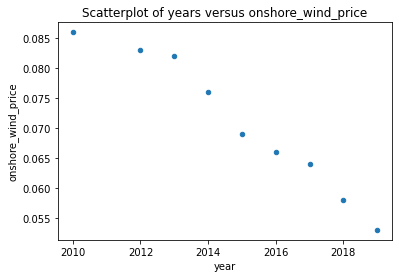

****************************************
Predicted prices of 'onshore_wind_price', 
y_pred=  [[ 0.05477097]
 [ 0.05087742]
 [ 0.04698387]
 [ 0.04309032]
 [ 0.03140968]
 [ 0.01972903]
 [ 0.01194194]
 [ 0.00026129]
 [-0.00752581]]
type(y_pred)=  <class 'numpy.ndarray'>


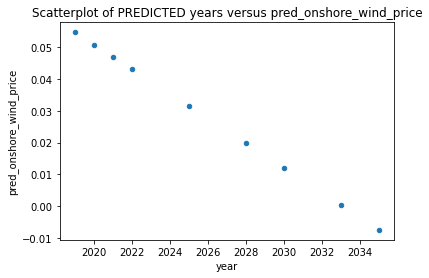

****************************************
Predicted prices of 'bioenergy_price', 
y_pred=  [[0.06598827]
 [0.0647565 ]
 [0.06352473]
 [0.06229295]
 [0.05859764]
 [0.05490233]
 [0.05243878]
 [0.04874347]
 [0.04627993]]
type(y_pred)=  <class 'numpy.ndarray'>
****************************************
Predicted prices of 'geothermal_price', 
y_pred=  [[0.07313046]
 [0.0745747 ]
 [0.07601893]
 [0.07746317]
 [0.08179588]
 [0.08612859]
 [0.08901706]
 [0.09334977]
 [0.09623824]]
type(y_pred)=  <class 'numpy.ndarray'>
****************************************
Predicted prices of 'offshore_wind_price', 
y_pred=  [[0.12736129]
 [0.12150323]
 [0.11564516]
 [0.1097871 ]
 [0.0922129 ]
 [0.07463871]
 [0.06292258]
 [0.04534839]
 [0.03363226]]
type(y_pred)=  <class 'numpy.ndarray'>
  country  year  pred_csp_price  pred_hydro_price  pred_solar_price  \
0   World  2019        0.190342          0.050436          0.031978   
1   World  2020        0.172558          0.051900          0.001396   
2   World  202

In [145]:
# Predict future prices using a linear regression model
def predict_future_prices(myDF, myCol):

    myPredCol = 'pred_' + myCol

    myX = np.asarray(
        df_energy_levelized_cost_World_NoNull['year'].values.astype('datetime64[D]'))
    type(myX)
    myX
    myX.ndim

    # Convert to 2D array
    myX = myX.reshape(-1, 1)
    myX.ndim
    myX.shape

    # put your y-values in here and cast the data type
    myY = np.asarray(
        df_energy_levelized_cost_World_NoNull[myCol].values.astype('float64'))
    myY = myY.reshape(-1, 1)
    myY
    type(myY)
    myY.shape

    # make scatter plots for all non-fossil energy columns in our World dataset (df_energy_levelized_cost_World_NoNull)
    # Nevertheless, I execute code for running the scatterplot not for every item. Instead, I let the code to run with one item as a demo!
    if myCol == 'onshore_wind_price':
        df_energy_levelized_cost_World_NoNull.plot.scatter(
            x='year', y=myCol, title=f'Scatterplot of years versus {myCol}')
        plt.show()

    model = LinearRegression()
    model.fit(myX, myY)

    # In order to predict prices and simultaneously test the model, I began from year 2019 to overlap the future!
    X_year_pred = np.asarray(
        [2019, 2020, 2021, 2022, 2025, 2028, 2030, 2033, 2035]).astype('float').reshape(-1, 1)
    X_year_pred

    y_pred = model.predict(X_year_pred)
    # Test case: y_pred = model.predict([[2025]])
    print('*' * 40)
    print(f"Predicted prices of '{myCol}', \ny_pred= ", f"{y_pred}")
    # print(f"Predicted prices of '{myCol}', \n{y_pred= }")
    print("type(y_pred)= ", f"{type(y_pred)}")
    # print(f"{type(y_pred)= }")

    df_pred_results[myPredCol] = y_pred

    # make scatter plots for PREDICTED non-fossil energy columns in our predicted dataset (df_pred_results) --> BEL
    if myPredCol == 'pred_onshore_wind_price':
        df_pred_results.plot.scatter(
            x='year', y=myPredCol, title=f'Scatterplot of PREDICTED years versus {myPredCol}')
        plt.show()

    return df_pred_results


# Predict future prices for non-fossil columns
for col in non_fossil_energy_price_columns:
    df_pred_results = predict_future_prices(df_pred_results, col)

# Predicted Prices are for the period [2019 - 2035].
# Be aware that I made an 'interesting' price comparison with some 'earlier' years just as a test !!
df_pred_results
print(df_pred_results)

In [146]:
# Determine "Best future price" for non-fossil energy (after carefully examining the predicted results dataframe)
df_Best_3_future_price_non_fossil = df_pred_results.loc[df_pred_results['year'] == 2035]

# Melt dataframe reform data in our favor
df_Best_3_future_price_non_fossil = df_Best_3_future_price_non_fossil.melt(
    id_vars=['country', 'year'])

# Rename columns to "pred_non_fossil_energy_tech" & "future_price_in_2035"
df_Best_3_future_price_non_fossil.rename(
    columns={"variable": "pred_non_fossil_energy_tech", 'value': 'pred_future_price_in_2035'}, inplace=True)

# Sort to determine which non-fossil fuel energy technology will have the best price in the future
df_Best_3_future_price_non_fossil = df_Best_3_future_price_non_fossil.sort_values(
    by=['pred_future_price_in_2035'], ascending=True)

df_Best_3_future_price_non_fossil.reset_index(drop=True, inplace=True)

print('*' * 70)
print("[Top 3 Best future price for non-fossil fuel energy]:")
print(df_Best_3_future_price_non_fossil)

**********************************************************************
[Top 3 Best future price for non-fossil fuel energy]:
  country  year pred_non_fossil_energy_tech  pred_future_price_in_2035
0   World  2035            pred_solar_price                  -0.457320
1   World  2035              pred_csp_price                  -0.094208
2   World  2035     pred_onshore_wind_price                  -0.007526
3   World  2035    pred_offshore_wind_price                   0.033632
4   World  2035        pred_bioenergy_price                   0.046280
5   World  2035            pred_hydro_price                   0.073854
6   World  2035       pred_geothermal_price                   0.096238


In [147]:
"""
Conclusion
----------
The top 3 non-fossil fuel energy technologies which will have the best price in the future are the following:
1) Solar energy as a whole.
2) CSP (Concentrated Solar Power) plants.
3) Onshore wind energy.

"""

# [ FOR FURTHER EXPLANATION PLEASE SEE MY FINAL REPORT FOR THIS ASSIGNMENT ] !!


# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
#                           THE END OF MY PY CODE
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

'\nConclusion\n----------\nThe top 3 non-fossil fuel energy technologies which will have the best price in the future are the following:\n1) Solar energy as a whole.\n2) CSP (Concentrated Solar Power) plants.\n3) Onshore wind energy.\n\n'